In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
import quandl
import tensorflow as tf

In [2]:
# Load the data
top10_data = pd.read_csv("data/return_data_top10.csv")

# Equalize the data
min_date = pd.to_datetime('2013-10-1')
top10_data = top10_data[top10_data.Date >= '2013-10-1']

In [3]:
df = pd.pivot_table(data=top10_data, columns=["Date"], index=["Ticker"], values="forward_return")
df.fillna(0.0, inplace=True)
df

Date,2013-10-10,2013-10-11,2013-10-14,2013-10-15,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,...,2017-09-15,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-25,2017-09-26,2017-09-27,2017-09-28
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.006482,0.006550,0.005322,0.004881,0.006757,0.008702,0.024508,-0.002867,0.009796,0.013239,...,-0.007568,0.000378,-0.016758,-0.017172,-0.009779,-0.008822,0.017204,0.007118,-0.006160,0.005480
BRK_B,0.008447,0.001641,-0.011810,0.017971,0.001971,0.000428,-0.000684,0.005133,-0.009192,0.003694,...,0.008783,0.008486,0.004426,-0.003590,-0.007098,0.003629,-0.003616,0.007753,-0.000327,0.000600
FB,0.001223,0.008145,-0.000202,0.033030,0.021023,0.038498,-0.006824,-0.021820,-0.014713,0.010501,...,-0.009150,0.014764,-0.002029,-0.006157,-0.003331,-0.044975,0.008227,0.021131,0.006262,0.012327
GE,0.006186,-0.000820,-0.007793,0.007028,0.013136,0.035251,0.023092,-0.004591,-0.012298,0.009339,...,0.022148,-0.010630,0.004959,0.017681,0.004848,0.009650,-0.007168,-0.022463,-0.005334,-0.002475
JNJ,0.019025,0.003913,0.001448,0.013121,0.009439,-0.003697,-0.004693,0.012719,-0.002815,0.002714,...,0.006917,-0.001182,-0.014791,-0.011034,-0.002732,-0.001674,-0.001753,-0.009088,-0.002158,0.004171
MSFT,0.010960,0.009376,0.001161,0.004349,0.008083,0.001145,0.000858,-0.011718,-0.023713,-0.001185,...,-0.001992,0.003725,-0.006628,-0.009741,0.002695,-0.015455,0.000000,0.008054,0.000271,0.008393
PG,0.007575,0.003313,-0.014478,0.017287,0.013786,-0.000126,-0.005541,0.017855,0.006594,-0.003708,...,-0.001287,0.010950,0.002442,-0.018644,-0.004318,0.005204,-0.000755,-0.019212,0.000220,0.000990
T,0.001464,-0.008187,-0.006191,0.014536,0.007018,0.004936,0.017625,0.000284,0.001391,-0.018396,...,0.008625,0.021112,0.005758,-0.005464,0.009681,0.013734,-0.010225,0.001291,0.006964,0.003330
WFC,-0.000241,0.007724,-0.005030,0.016129,0.011135,0.000000,-0.001406,0.007508,-0.004192,-0.001637,...,0.020325,0.012332,0.007309,0.005767,0.003515,-0.004055,-0.004257,0.007621,0.000738,0.016590


In [4]:
#https://github.com/tensorflow/nmt#training--how-to-build-our-first-nmt-system
# Network Parameters
hidden_dim = 4
batch_size = 1
source_sequence_length = 500
num_tickers = 10
_time_major = True 
Pin = 1.0
Pout = 0.80
Pstate = 0.80
learning_rate = 1e-3

"""
 If true, these Tensors must be shaped [max_time, batch_size, depth]. 
 If false, these Tensors must be shaped [batch_size, max_time, depth]. 
 Using time_major = True is a bit more efficient
"""

# Reset the graph
tf.reset_default_graph()

# Graph Placeholders
encoder_inputs = tf.placeholder(shape=(None, None, num_tickers), 
                                dtype=tf.float64, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None, num_tickers), 
                                 dtype=tf.float64, name='decoder_targets')

# Build Encoder cell
encoder_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden_dim,
                                       forget_bias=1.0,
                                       state_is_tuple=True,
                                       activation=tf.tanh,
                                       reuse=None)

# Introduce Dropout to the Encoding
encoder_dropout = tf.contrib.rnn.DropoutWrapper(encoder_cell,
                                                input_keep_prob=Pin,
                                                output_keep_prob=Pout,
                                                state_keep_prob=Pstate)

# Build Simple Decoder Cell
decoder_cell = tf.nn.rnn_cell.LSTMCell(num_units=num_tickers,
                                       forget_bias=1.0,
                                       state_is_tuple=True,
                                       activation=tf.tanh,
                                       reuse=None)

# Compile Deep Network
autoencoder_layers = tf.nn.rnn_cell.MultiRNNCell([encoder_dropout, decoder_cell], 
                                             state_is_tuple=True)


# Run Dynamic RNN
#   encoder_outpus: [batch_size, max_time, num_units]
#   encoder_state: [batch_size, num_units]
outputs, state = tf.nn.dynamic_rnn(autoencoder_layers,
                                   encoder_inputs,
                                   sequence_length=[source_sequence_length],
                                   time_major=_time_major,
                                   dtype=tf.float64)

# Loss Metric (unregularized)
loss = tf.losses.mean_squared_error(labels=decoder_targets, predictions=outputs)
loss = tf.reduce_mean(loss)

# Optimizer
trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [5]:
# Training function
num_steps = 3500
x_train = df.values[0:, :500].T.reshape((500, 1, 10))
y_train = df.values[0:, :500].T.reshape((500, 1, 10))

tic = time.time()        # Initialize time count
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        _, train_loss, pred = sess.run([optimizer, loss, outputs], feed_dict={encoder_inputs:x_train,
                                                                              decoder_targets:y_train})

        if (step % 50 == 0):
            val_loss = sess.run([loss], feed_dict={encoder_inputs:x_train,
                                                   decoder_targets:y_train})
            print("-"*50)
            print("Training step: {0} - Loss = {1}".format(step, val_loss))
        # when achieve the best validation accuracy, we store the model paramters
        if step == (num_steps-1):
            saver.save(sess, 'model/auto_encode_model')
    print("="*50)
toc = time.time()
print("Overall Training Time: {}".format(toc-tic))

--------------------------------------------------
Training step: 0 - Loss = [0.00016332533]
--------------------------------------------------
Training step: 50 - Loss = [0.00015739618]
--------------------------------------------------
Training step: 100 - Loss = [0.00015608188]
--------------------------------------------------
Training step: 150 - Loss = [0.00015173558]
--------------------------------------------------
Training step: 200 - Loss = [0.00014437435]
--------------------------------------------------
Training step: 250 - Loss = [0.00012648327]
--------------------------------------------------
Training step: 300 - Loss = [0.00010643746]
--------------------------------------------------
Training step: 350 - Loss = [9.6031523e-05]
--------------------------------------------------
Training step: 400 - Loss = [9.3499541e-05]
--------------------------------------------------
Training step: 450 - Loss = [9.0567562e-05]
--------------------------------------------------
Tr

In [6]:
x_test = df.values[0:, 500:].T.reshape((500, 1, 10))
y_test = df.values[0:, 500:].T.reshape((500, 1, 10))

pred = None
with tf.Session() as sess: 

    saver = tf.train.import_meta_graph('model/auto_encode_model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    
    graph = tf.get_default_graph()
    
    tf_input = graph.get_operations()[0].name+':0'
    x = graph.get_tensor_by_name(tf_input)
    tf_label = graph.get_operations()[1].name+':0'
    y = graph.get_tensor_by_name(tf_label)
    pred = sess.run(outputs, feed_dict={x:x_test, y:y_test})


INFO:tensorflow:Restoring parameters from model/auto_encode_model


In [7]:
# Format the test returns into cummulative returns

df_test = pd.DataFrame(data=x_test.reshape(500,10), columns=df.index.values)
df_test += 1
df_test = df_test.cumprod(axis=0)

# Format the predicted values
df_pred = pd.DataFrame(data=pred.reshape((500,10)), columns=df_test.columns)
df_pred += 1
df_pred = df_pred.cumprod(axis=0)



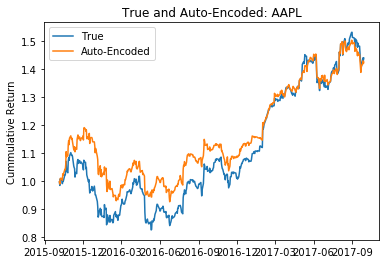

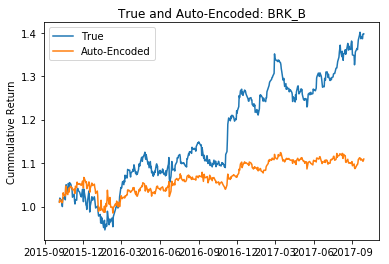

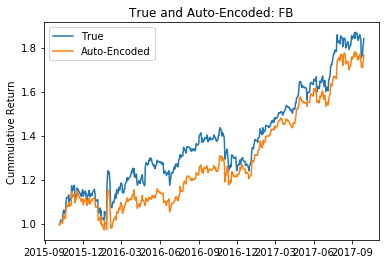

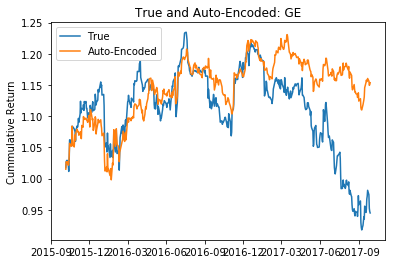

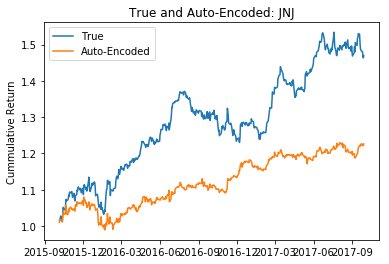

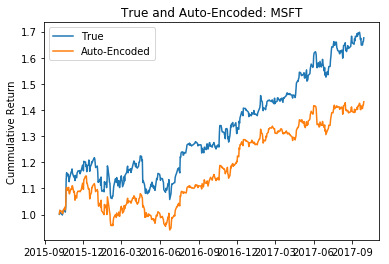

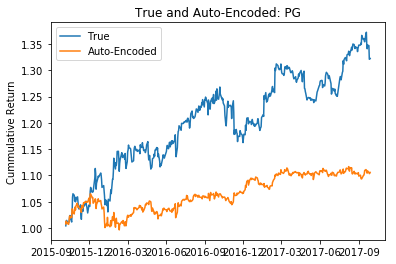

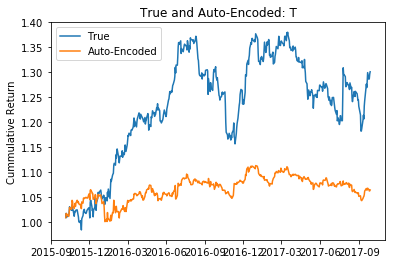

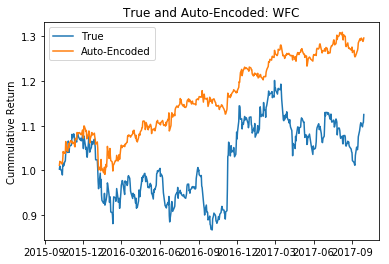

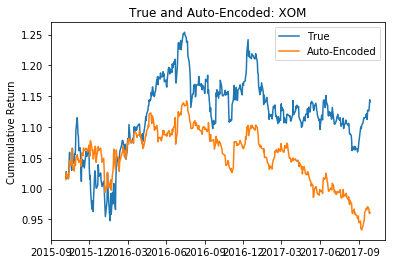

In [8]:
%matplotlib inline


test_stocks = df.index.tolist()
dates = pd.to_datetime(df.columns.tolist()[500:])

for stock in test_stocks:
    plt.figure()
    plt.plot(dates, df_test[stock],dates, df_pred[stock])
    plt.title("True and Auto-Encoded: {}".format(stock))
    plt.legend(['True', 'Auto-Encoded'])
    plt.ylabel("Cummulative Return")